<a href="https://colab.research.google.com/github/YassineZITI/IT-or-Not-Books-/blob/main/Pre_processing_%26_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## in this last notebook we will build our classifier using keras.

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pickle
with open('/content/drive/My Drive/data_t.txt', 'rb') as f:
    df = pickle.load( f)


In [ ]:
import pandas as pd
df.head()

,title,description,genres,len
0,The Hunger Games,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,Not,147.0
1,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Not,136.0
2,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Not,137.0
3,Pride and Prejudice,Alternate cover edition of ISBN 9780679783268S...,Not,100.0
4,Twilight,About three things I was absolutely positive.\...,Not,51.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7391 entries, 0 to 3410
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        7391 non-null   object 
 1   description  7391 non-null   object 
 2   genres       7391 non-null   object 
 3   len          7391 non-null   float64
dtypes: float64(1), object(3)
memory usage: 288.7+ KB


In [ ]:
df.describe()

,len
count,7391.000000
mean,146.167501
std,67.157088
min,16.000000
25%,99.000000
50%,136.000000
75%,186.000000
max,686.000000


# Explore Data & Clean

In [ ]:
df['description'].iloc[4200]

" If you need to deploy, manage, or secure Microsoft SQL Server 2008, this is the complete, fast-paced, task-based reference you've been searching for. Authored by a world-class expert on SQL Server in the enterprise, this book goes far beyond the basics, taking on the complex tasks that DBAs need to make the most of Microsoft's flagship database platform. SQL Server MVP, Ross Mistry presents proven techniques for SQL Server 2008 installation, upgrades, backup/restore, data transfer, indexing, high availability, security, and much more. He draws on extensive testing in high-profile production environments to offer step-by-step solutions and powerful tips you won't find anywhere else.    "

In [ ]:
!pip install pycld2 -q

     |████████████████████████████████| 41.4 MB 1.4 MB/s 


In [ ]:
# check the language  (we filtered the non english in data collection step based on language feature now we check it maually)
import pycld2 as cld2
def detect_lang(row):
  try:
    _, _, details = cld2.detect(row
  )
    return details[0][0].capitalize()
  except:
    return None

In [ ]:
df['lang'] = df['description'].apply(lambda row:detect_lang(row))

In [ ]:
(df['lang'] == 'English').sum()

7367

In [ ]:
df[df['lang'].isnull()]

,title,description,genres,len,lang
1121,The Immortal Rules,"To survive in a ruined world, she must embrace...",Not,145.0,None
1752,Raintree County,"Throughout a single day in 1892, John Shawness...",Not,116.0,None
1956,Perelandra,The second book in C. S. Lewis's acclaimed Spa...,Not,123.0,None
3083,Vampire Kisses,"In her small town, dubbed ""Dullsville,"" sixtee...",Not,130.0,None
3410,The Information,"Fame, envy, lust, violence, intrigues literary...",Not,103.0,None
3708,Trout Fishing in America,Richard Brautigan was a literary idol of the 1...,Not,99.0,None
4027,The Underneath,There is nothing lonelier than a cat who has b...,Not,219.0,None
497,Deploying SharePoint 2019,Update to a version of SharePoint that offers...,IT,202.0,None
2241,Big Data Architect's Handbook,The big data architects are the â€œmastersâ€...,IT,208.0,None
2399,Microsoft Excel 2019 Pivot Table Data Crunching,Renowned Excel experts Bill Jelen (MrExcel) a...,IT,263.0,None


In [ ]:
#i manually checked all these rows there are all english.
# let's keep them
df = df[(df['lang'] == 'English') | (df['lang'].isnull())]
df.lang.value_counts(dropna=False)

English    7367
NaN          12
Name: lang, dtype: int64

In [ ]:
!pip install nltk --q
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#clean descriptions
import re
from nltk.corpus import stopwords


stop_words = set(stopwords.words('english'))
#remove punctuation
def remove_punctuation_digits(desc):
  clean = re.sub('[^A-Za-z]+',' ',desc)
  return clean
#remove stop words
def remove_stop_words(desc):
  clean = ' '.join([i for i in desc.split(' ') if i not in stop_words])
  return clean

def clean_text(desc):
  desc = remove_punctuation_digits(desc)
  desc = desc.lower()
  #remove newlines and whitelines
  desc = re.sub('\n|\r',' ',desc)
  return remove_stop_words(desc).strip()

In [ ]:
#apply to dataframe
df['description_cleaned'] = df['description'].apply(lambda x:clean_text(x))
df['description_cleaned'].iloc[500]

'tormented orphan clubfoot philip carey grows impressionable young man voracious appetite adventure knowledge cravings take paris age eighteen try hand art back london study medicine even nothing sate nagging hunger experience falls obsessively love embarking disastrous relationship change life forever marked countless similarities maugham life masterpiece autobiography author contended autobiographical novel fact fiction inexorably mingled emotions'

# Load GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-07-02 11:11:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-02 11:11:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-02 11:11:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
vec = pd.read_csv('/content/glove.6B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)

In [ ]:
vec.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621


In [ ]:
glove = {key: val.values for key, val in vec.T.items()}

# Embeding Matrix

In [ ]:
!pip install tensorflow -q

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['description_cleaned'])

In [ ]:
word_index = tokenizer.word_index


In [ ]:
#count out of vocabulary words
oov = []
for word in word_index.keys():
  if word not in glove.keys():
    oov.append(word)

In [ ]:
len(oov)

4044

In [ ]:
print(int(len(oov)/len(word_index.keys())*100),'% of training data words are out of glove vocabulary')

10 % of training data words are out of glove vocabulary


In [ ]:
#@title stemming and lemmatization
#lemmatization and stemming
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

for word in oov:
  if porter_stemmer.stem(word) in glove.keys():
    oov.remove(word)
    continue
  if wordnet_lemmatizer.lemmatize(word) in glove.keys():
    oov.remove(word)
print(int(len(oov)/len(word_index.keys())*100),'% of training data words are out of glove vocabulary')

In [ ]:
#count oov occurences
counts = {w:[0,0] for w in oov}
desc = df['description_cleaned'].values
for i in range(len(desc)):
  sen = desc[i]
  for w in sen.split(' '):
    if w in oov:
      counts[w][0]+=1
      counts[w][1]+=i
  

In [ ]:
# top oov
[key for key,value in counts.items() if value[0]>10]

['tensorflow',
 'microservices',
 'kubernetes',
 'devops',
 'serverless',
 'blockchain',
 'pytorch',
 'solr',
 'elasticsearch',
 'blazor',
 'xamarin',
 'scikit',
 'splunk',
 'shadowhunters',
 'jupyter',
 'redis',
 'matplotlib',
 'chatbots',
 'hbase',
 'microservice',
 'couchbase',
 'angularjs',
 'graphql',
 'opencv',
 'mesos',
 'ipython',
 'scipy',
 'vsphere',
 'rabbitmq',
 'rstudio',
 'chatbot',
 'pyspark',
 'architecting',
 'ggplot',
 'beaglebone',
 'hdfs',
 'cnns',
 'automl',
 'exadata',
 'ethereum',
 'qgis',
 'performant',
 'rnns',
 'gephi',
 'openacc',
 'shadowhunter',
 'celaena',
 'dsls',
 'autoencoders',
 'mllib',
 'qlikview',
 'couchdb',
 'laravel',
 'mvvm',
 'feyre',
 'pentaho',
 'pytest',
 'istio',
 'vsts',
 'lightswitch',
 'rman',
 'polybase',
 'grpc',
 'columnstore',
 'lumion',
 'async',
 'vuex',
 'innodb',
 'bigquery',
 'phonegap',
 'hyperledger',
 'openshift',
 'accumulo',
 'directaccess']

In [ ]:
len([key for key,value in counts.items() if value[0]>10])

74

In [ ]:
# most of those top oov are computer science words and authors names
# and the others aren't important because they aren't very frequent
# so well delete them
def delete_oov(words,row):
  row = row.split(' ')
  row = [w for w in row if w not in words]
  return ' '.join(row)


In [ ]:
df['description_cleaned'] = df['description_cleaned'].apply(lambda row:delete_oov(oov,row))

In [ ]:
df['description_cleaned']

0       winning means fame fortune losing means certai...
1       door end silent corridor haunting harry dreams...
2       unforgettable novel childhood sleepy southern ...
3       alternate cover edition isbn since immediate s...
4       three things absolutely positive first edward ...
                              ...                        
3406    gain solid understanding capabilities provided...
3407    understand advanced topics app v identify rare...
3408    without comprehensive understanding deployment...
3409    develop powerful successful dynamics ax projec...
3410    open data protocol web protocol querying updat...
Name: description_cleaned, Length: 7379, dtype: object

In [ ]:
df['len'] = df['description_cleaned'].apply(lambda x:len(x.split(' ')))

In [ ]:
df.describe()

,len
count,7379.000000
mean,82.952975
std,38.987279
min,7.000000
25%,55.000000
50%,76.000000
75%,105.000000
max,373.000000


(0.0, 700.0)

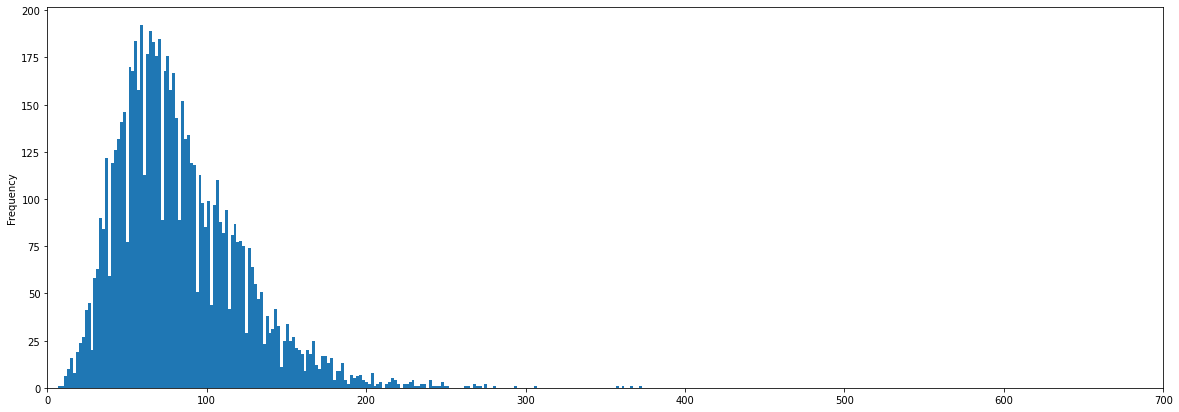

In [ ]:
#description lengths
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize = (20, 7))
df['len'].plot.hist(bins=200)
plt.xlim(0,700)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['description_cleaned'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['description_cleaned'])
maxlen = 100 #longer than most of the descriptions

In [ ]:
X = pad_sequences(sequences,maxlen=maxlen,padding='post')

In [ ]:
X[3311]

array([   65,   272,   247,  1045,  2809,  8990,  2815, 20575,   490,
          22,   627,   839,  1046, 29241,  3081,   253,    20, 17979,
        3835,  1353,  2556,   504,   534,  1500,   457,   271,   304,
          10,   408, 20575,  2099,     3,    46,    69,  2651,   451,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
import numpy as np

word_to_index = word_index
word_to_vec_map = glove
vocab_size = len(word_to_index) + 1              
any_word = list(word_to_vec_map.keys())[0]
emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of GloVe word vectors

emb_matrix = np.zeros([vocab_size,emb_dim])

for word, idx in word_to_index.items():
    
# create a weight matrix for words in training sentences
  emb_matrix[idx, :] = word_to_vec_map[word]
  
  

In [ ]:
print(emb_matrix.shape)
emb_matrix[0]

(33054, 300)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Split Data

In [ ]:
# we can use sklearn train_test_split 
# i were trying to do a multi label classification 
# so this function is good for stratifying multi labels data
# in case feel free to use it


from copy import deepcopy
import numpy as np



def stratify(data, classes, ratios):
    """Stratifying procedure.

    data is a list of lists: a list of labels, for each sample.it can be a series 
    
    classes is the list of classes each label can take

    ratios is a list, summing to 1, of how the dataset should be split

    """
    data = [[d] for i, d in enumerate(data)]
    # Organize data per label: for each label l, per_label_data[l] contains the list of samples
    # in data which have this label
    per_label_data = {c: set() for c in classes}
    for i, d in enumerate(data):
        for l in d:
          per_label_data[l].add(i)
    # number of samples
    size = len(data)

    # In order not to compute lengths each time, they are tracked here.
    subset_sizes = [r * size for r in ratios]
    target_subset_sizes = deepcopy(subset_sizes)
    per_label_subset_sizes = {
        c: [r * len(per_label_data[c]) for r in ratios]
        for c in classes
    }
    # For each subset we want, the set of sample-ids which should end up in it
    stratified_data_ids = [set() for _ in range(len(ratios))]

    # For each sample in the data set
    while size > 0:
        # Compute |Di|
        lengths = {
            l: len(label_data)
            for l, label_data in per_label_data.items()
        }
        try:
            # Find label of smallest |Di|
            label = min(
                {k: v for k, v in lengths.items() if v > 0}, key=lengths.get
            )
        except ValueError:
            # If the dictionary in `min` is empty we get a Value Error. 
            # This can happen if there are unlabeled samples.
            # In this case, `size` would be > 0 but only samples without label would remain.
            # "No label" could be a class in itself: it's up to you to format your data accordingly.
            break
        current_length = lengths[label]

        # For each sample with label `label`
        while per_label_data[label]:
            # Select such a sample
            current_id = per_label_data[label].pop()

            subset_sizes_for_label = per_label_subset_sizes[label]
            # Find argmax clj i.e. subset in greatest need of the current label
            largest_subsets = np.argwhere(
                subset_sizes_for_label == np.amax(subset_sizes_for_label)
            ).flatten()

            if len(largest_subsets) == 1:
                subset = largest_subsets[0]
            # If there is more than one such subset, find the one in greatest need
            # of any label
            else:
                largest_subsets = np.argwhere(
                    subset_sizes == np.amax(subset_sizes)
                ).flatten()
                if len(largest_subsets) == 1:
                    subset = largest_subsets[0]
                else:
                    # If there is more than one such subset, choose at random
                    subset = np.random.choice(largest_subsets)

            # Store the sample's id in the selected subset
            stratified_data_ids[subset].add(current_id)

            # There is one fewer sample to distribute
            size -= 1
            # The selected subset needs one fewer sample
            subset_sizes[subset] -= 1

            # In the selected subset, there is one more example for each label
            # the current sample has
            for l in data[current_id]:
                per_label_subset_sizes[l][subset] -= 1
            
            # Remove the sample from the dataset, meaning from all per_label dataset created
            for l, label_data in per_label_data.items():
                if current_id in label_data:
                    label_data.remove(current_id)

    # Create the stratified dataset as a list of subsets, each containing the orginal labels
    stratified_data_ids = [sorted(strat) for strat in stratified_data_ids]
    

    # Return both the stratified indexes, to be used to sample the `features` associated with your labels
    return stratified_data_ids

In [ ]:
data = df['genres']
classes = ['IT', 'Not']
splits_indexes = stratify(data, classes, [0.7,0.3])

In [ ]:
# output
# we can also use keras to_categorical
def Output(ser,classes):
  rows = len(ser)
  cols = len(classes) 
  out = np.zeros((rows,cols))
  for i in range(rows):
    for j in range(cols):
      cls = classes[j]
      if cls in ser[i]:
        out[i,j] = 1
  return out

In [ ]:
y = Output(df['genres'],classes)

In [ ]:
y[0]

array([0., 1.])

In [ ]:
def split_data(df,test_size,tokenizer):
  sequences = tokenizer.texts_to_sequences(df['description_cleaned'])
  maxlen = 100
  X = pad_sequences(sequences,maxlen=maxlen,padding='post')
  data = df['genres']
  classes = ['IT', 'Not']
  splits_indexes = stratify(data, classes, [1-test_size,test_size])
  y = Output(df['genres'],classes)
  x_train = X[splits_indexes[0]]
  x_test = X[splits_indexes[1]]
  y_train = y[splits_indexes[0]]
  y_test = y[splits_indexes[1]]
  return x_train,x_test,y_train,y_test

In [ ]:
#train test split
x_train,x_test,y_train,y_test = split_data(df,0.3,tokenizer)


In [ ]:
y_train.shape

(5166, 2)

# Model

In [ ]:
#save embedding matrix to use it in the application
import pickle
with open('/content/drive/My Drive/emb_matrix.pkl', 'wb') as f:
    pickle.dump(emb_matrix,f)

In [ ]:
#import necessary libraries for the model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, Lambda, LSTM
from tensorflow.keras.layers import Embedding

In [ ]:

def Average_Model(emb_matrix,maxlen,num_classes):
  model = Sequential()
  model.add(Embedding(input_dim=emb_matrix.shape[0], output_dim=emb_matrix.shape[1], input_length=maxlen , weights=[emb_matrix]))
  # Average the output of the Embedding layer over the word dimension
  model.add(Lambda(lambda x: tf.keras.backend.mean(x, axis=1)))
  model.add(Dense(num_classes,activation='sigmoid'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:

def LSTM_Model(emb_matrix,maxlen,num_classes):
  model = Sequential()
  model.add(Embedding(input_dim=emb_matrix.shape[0], output_dim=emb_matrix.shape[1], input_length=maxlen , weights=[emb_matrix]))
  #model.add(LSTM(units=128,return_sequences = True))
  #model.add(Dropout(0.5))
  model.add(LSTM(units=128,return_sequences = False))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes,activation='sigmoid'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = Average_Model(emb_matrix,100,len(classes))

In [ ]:
model.fit(x_train, y_train, batch_size=128, epochs=3, verbose=1)

Epoch 1/3
41/41 [==============================] - 6s 121ms/step - loss: 0.5386 - accuracy: 0.8134
Epoch 2/3
41/41 [==============================] - 5s 122ms/step - loss: 0.2498 - accuracy: 0.9737
Epoch 3/3
41/41 [==============================] - 5s 121ms/step - loss: 0.1225 - accuracy: 0.9940


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.10854383558034897
Test accuracy: 0.9932218790054321


In [ ]:
lstm = LSTM_Model(emb_matrix,100,len(classes))

In [ ]:
lstm.fit(x_train, y_train, batch_size=128, epochs=3, verbose=1)

Epoch 1/3
41/41 [==============================] - 27s 610ms/step - loss: 0.1935 - accuracy: 0.9367
Epoch 2/3
41/41 [==============================] - 25s 599ms/step - loss: 0.0520 - accuracy: 0.9899
Epoch 3/3
41/41 [==============================] - 24s 593ms/step - loss: 0.0209 - accuracy: 0.9967


In [ ]:
score = lstm.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.03846379742026329
Test accuracy: 0.9936737418174744


In [ ]:
# to see the most confident model
def good(pred):
  
  pred = (pred > 0.8)*1
  return pred

In [ ]:
indx = np.random.randint(0,5000, size=1)
input_data = x_train[indx]
pred1 = model.predict(input_data)
pred2 = lstm.predict(input_data)
print(indx)
print(pred1)
print(pred2)
print(classes)
print(good(pred1))
print(y_train[indx].astype(int))

[2454]
[[0.18458986 0.808797  ]]
[[0.08733961 0.96552753]]
['IT', 'Not']
[[0 1]]
[[0 1]]


In [ ]:
# saving

lstm.save('/content/drive/My Drive/classifier.h5')



In [ ]:
with open('/content/drive/My Drive/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)